## Load Libraries

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
import seaborn as sns
from scipy.linalg import svd
from numpy.linalg import lstsq, inv

## Import Data

In [7]:
# Loading the data
data = pd.read_csv('PredictorLSretWide.csv', parse_dates=['date'])
#data

In [9]:
data = data.sort_values('date')
data.set_index('date', inplace=True)

In [17]:
# Compute % of missing values across all predictors, year by year
missing_by_year = data.isnull().mean(axis=1).resample('Y').mean()

/var/folders/cx/s4m8hx111pg6r7nkxdrwj4gm0000gn/T/ipykernel_89413/595006155.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  missing_by_year = data.isnull().mean(axis=1).resample('Y').mean()


In [19]:
start_year = missing_by_year[missing_by_year < 0.15].index.min()

# Keep only data from this year onward
data = data[data.index >= start_year]
#data

In [21]:
col_missing_ratio = data.isnull().mean()
data = data.loc[:, col_missing_ratio <= 0.15]
#data

In [23]:
data = data.interpolate(method='linear')
data = data.fillna(method='ffill').fillna(method='bfill')
#data

/var/folders/cx/s4m8hx111pg6r7nkxdrwj4gm0000gn/T/ipykernel_89413/1981108245.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill').fillna(method='bfill')


In [25]:
# Extract momentum-related predictors for gt
momentum_keywords = ['Mom', 'Reversal', 'ResidualMomentum', 'LRreversal', 'MRreversal', 'STreversal']
momentum_cols = [col for col in data.columns if any(k in col for k in momentum_keywords)]

if not momentum_cols:
    raise ValueError("No momentum-related columns found. Adjust keyword list if needed.")

# Create gt matrix from selected momentum predictors (d × T)
gt = data[momentum_cols].transpose().values  # shape: (d, time)

# Remove gt columns from data to prevent leakage into rt
data_rt = data.drop(columns=momentum_cols)

# Create rt matrix from remaining predictors (N × T)
rt = data_rt.transpose().values

## Supervised Principal Components Analysis

This is the matlab code converted to Python code

This function extracts latent factors from asset return data (rt) using side information (gt) such as economic indicators or firm-level characteristics. It also optionally computes asymptotic variances for inference.

# Steps

1: Data Centring

* Remove the mean from rt and gt across time.

2: Iterative Factor Construction (loop over pmax factors) so for each potential factor

* Compute correlations between each asset and each factor proxy.
* Retain top N0 assets with strongest correlation (II).
* Perform SVD on the selected returns rt0[II, :] to extract a latent factor.
* Store factor loadings (B), gamma coefficients (gammahat_all), and projections of gt on the latent factor direction (etahat_all).
* Deflate gt and rt to remove explained variation.

3: Model Estimation for Each Candidate Number of Factors (usep)

For each phat in usep compute:

* Gammahat_nozero: SPCA projection of proxies on latent factors.
* b: Estimated betas (regression coefficients).
* mimi: Matrix of SPCA factor exposures by asset.
* alphahat: Intercepts for projection residuals.

If return_variance=True, also compute:

* avarhat_nozero: Asymptotic variance of Gammahat.
* avarhat_alpha: Asymptotic variance of alphahat.
* These use Newey-West-style HAC estimators.



In [30]:
def vec(matrix):
    return matrix.flatten(order='F')

def SPCA_cv(param, return_variance=False):
    rt = param['rt']
    gt = param['gt']
    usep = param['usep']
    N0 = param['tuning']
    q = param.get('q', 1)

    T = rt.shape[1]
    n = rt.shape[0]
    d = gt.shape[0]
    J = len(usep)
    pmax = max(usep)

    rtbar = rt - np.mean(rt, axis=1, keepdims=True)
    gtbar = gt - np.mean(gt, axis=1, keepdims=True)
    etahat_all = np.zeros((d, pmax))
    gammahat_all = np.zeros((pmax, 1))
    Index = np.zeros((n, pmax))
    B = np.zeros((pmax, n))
    mrt = np.mean(rt, axis=1, keepdims=True)
    mrt0 = mrt.copy()
    vhat_all = np.zeros((pmax, T))

    rt0 = rtbar.copy()
    gt0 = gtbar.copy()

    Gammahat_nozero = np.zeros((d, J))
    b = np.zeros((J, n))
    mimi = np.zeros((d, n, J))
    avarhat_nozero = np.zeros((d, J))
    alphahat = np.zeros((d, J))
    avarhat_alpha = np.zeros((d, J))

    k = 0
    while k < pmax:
        COR = np.abs(np.corrcoef(rt0, gt0)[0:n, n:])
        L = np.max(COR, axis=1)
        bb = np.sort(L)
        if N0 < n:
            II = L >= bb[n - N0]
        else:
            II = L > -1

        k += 1
        Index[:, k - 1] = 0
        Index[II, k - 1] = 1

        U, S, Vt = svd(rt0[II, :], full_matrices=False)
        U = U[:, :1]
        S = S[:1]
        V = Vt[:1, :].T

        B[k - 1, II] = (U[:, 0] / S[0])
        gammahat_all[k - 1, 0] = (U[:, 0].T @ mrt0[II]) / S[0]
        etahat_all[:, k - 1] = (gt0 @ V).flatten()

        gt0 -= gt0 @ V @ V.T
        mrt0 -= (rt0 @ V) * gammahat_all[k - 1, 0]
        rt0 -= rt0 @ V @ V.T
        vhat_all[k - 1, :] = V.T

    for jj in range(J):
        phat = usep[jj]
        vhat = vhat_all[:phat, :]
        etahat = etahat_all[:, :phat]
        gammahat = gammahat_all[:phat, :]
        Sigmavhat = vhat @ vhat.T / T
        what = gtbar - etahat @ vhat

        if return_variance:
            Pi11hat = np.zeros((d * phat, d * phat))
            Pi12hat = np.zeros((d * phat, phat))
            Pi22hat = np.zeros((phat, phat))
            Pi13hat = np.zeros((d * phat, d))
            Pi33hat = np.zeros((d, d))

            for t in range(T):
                wt_vt = np.outer(what[:, t], vhat[:, t])
                vt = vhat[:, t]
                wt = what[:, t]

                Pi11hat += np.outer(vec(wt_vt), vec(wt_vt)) / T
                Pi12hat += np.outer(vec(wt_vt), vt) / T
                Pi22hat += np.outer(vt, vt) / T
                Pi13hat += np.outer(vec(wt_vt), wt) / T
                Pi33hat += np.outer(wt, wt) / T

                for s in range(1, min(t, q) + 1):
                    wts = what[:, t - s]
                    vts = vhat[:, t - s]
                    wt_vs = np.outer(wts, vts)

                    weight = 1 / T * (1 - s / (q + 1))
                    Pi11hat += weight * (np.outer(vec(wt_vt), vec(wt_vs)) + np.outer(vec(wt_vs), vec(wt_vt)))
                    Pi12hat += weight * (np.outer(vec(wt_vt), vts) + np.outer(vec(wt_vs), vt))
                    Pi22hat += weight * (np.outer(vt, vts) + np.outer(vts, vt))
                    Pi13hat += weight * (np.outer(vec(wt_vt), wts) + np.outer(vec(wt_vs), wt))
                    Pi33hat += weight * (np.outer(wt, wts) + np.outer(wts, wt))

            kron_term = np.kron(gammahat.T @ inv(Sigmavhat), np.eye(d))
            avarhat_nozero[:, jj] = np.diag(
                (kron_term @ Pi11hat @ kron_term.T +
                 kron_term @ Pi12hat @ etahat.T +
                 (kron_term @ Pi12hat @ etahat.T).T +
                 etahat @ Pi22hat @ etahat.T) / T
            )

        Gammahat_nozero[:, jj] = (etahat @ gammahat).flatten()

        B_sub = B[:phat, :]
        fhat = B_sub @ rt
        fhatbar = fhat - np.mean(fhat, axis=1, keepdims=True)
        mimi[:, :, jj] = (gt - np.mean(gt, axis=1, keepdims=True)) @ fhatbar.T @ inv(fhatbar @ fhatbar.T) @ B_sub
        b[jj, :] = (np.mean(fhat, axis=1).T @ inv(fhatbar @ fhatbar.T / T)) @ B_sub

        alphahat[:, jj] = np.mean(gt, axis=1) - Gammahat_nozero[:, jj]
        if return_variance:
            avarhat_alpha[:, jj] = np.diag(
                (kron_term @ Pi11hat @ kron_term.T -
                 kron_term @ Pi13hat -
                 (kron_term @ Pi13hat).T +
                 Pi33hat) / T
            )

    res = {
        'Gammahat_nozero': Gammahat_nozero,
        'b': b,
        'mimi': mimi,
        'alphahat': alphahat,
        'etahat': etahat_all,
        'gammahat': gammahat_all
    }

    if return_variance:
        res['avarhat_nozero'] = avarhat_nozero
        res['avarhat_alpha'] = avarhat_alpha

    return res


# Output dictionary 

| Key                 | Shape       | Description                                                   |
|---------------------|-------------|---------------------------------------------------------------|
| `'Gammahat_nozero'` | (d × J)     | Projections of factor proxies on latent SPCA factors.         |
| `'b'`               | (J × n)     | Estimated factor betas across assets.                         |
| `'mimi'`            | (d × n × J) | SPCA coefficients mapping characteristics to asset returns.   |
| `'alphahat'`        | (d × J)     | Intercepts from the projection of characteristics.            |
| `'etahat'`          | (d × pmax)  | Proxy components (proxies projected onto latent factors).     |
| `'gammahat'`        | (pmax × 1)  | Coefficients from mean returns projected on latent factors.   |
| `'avarhat_nozero'`  | (d × J)     | Variance of `Gammahat_nozero` (if `return_variance=True`).    |
| `'avarhat_alpha'`   | (d × J)     | Variance of `alphahat` (if `return_variance=True`).           |


# Summary

* Extracts up to pmax latent supervised principal components from returns.
* Uses side information (gt) to guide factor selection.
* Projects characteristics (gt) onto these latent factors.
* Returns the regression-like structure of returns on these latent factors.
* Optionally computes robust variances for inference.

In [38]:
param = {
    'rt': rt,  # (n x T) matrix of asset returns
    'gt': gt,  # (d x T) matrix of factor proxies
    'usep': [1, 2, 3, 4, 5],  # list of p values to estimate
    'tuning': 50,  # number of test assets at each step
    'q': 1  # Newey-West lag parameter (optional)
}
results = SPCA_cv(param, return_variance=True)

/var/folders/cx/s4m8hx111pg6r7nkxdrwj4gm0000gn/T/ipykernel_89413/3683259047.py:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gammahat_all[k - 1, 0] = (U[:, 0].T @ mrt0[II]) / S[0]


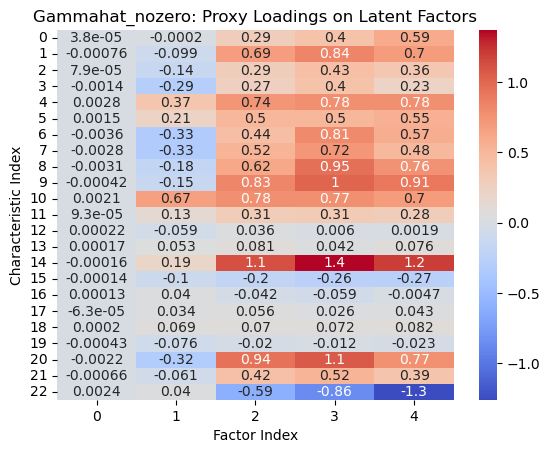

In [40]:
sns.heatmap(results['Gammahat_nozero'], cmap='coolwarm', annot=True)
plt.title('Gammahat_nozero: Proxy Loadings on Latent Factors')
plt.xlabel('Factor Index')
plt.ylabel('Characteristic Index')
plt.show()

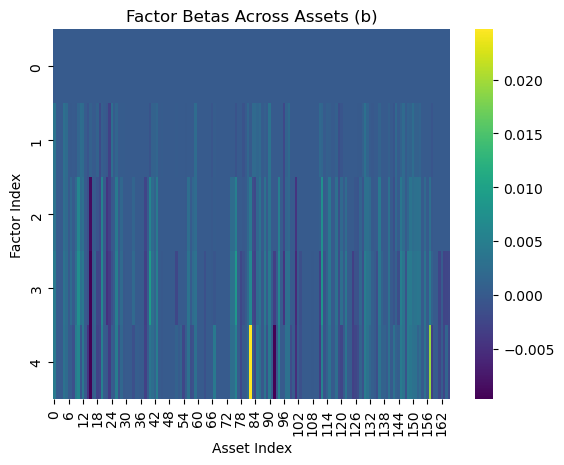

In [42]:
sns.heatmap(results['b'], cmap='viridis')
plt.title('Factor Betas Across Assets (b)')
plt.xlabel('Asset Index')
plt.ylabel('Factor Index')
plt.show()

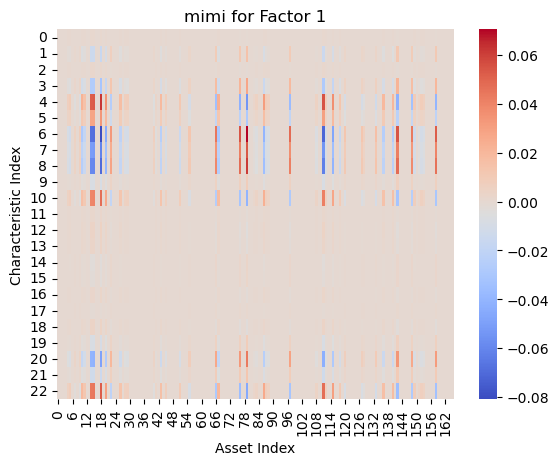

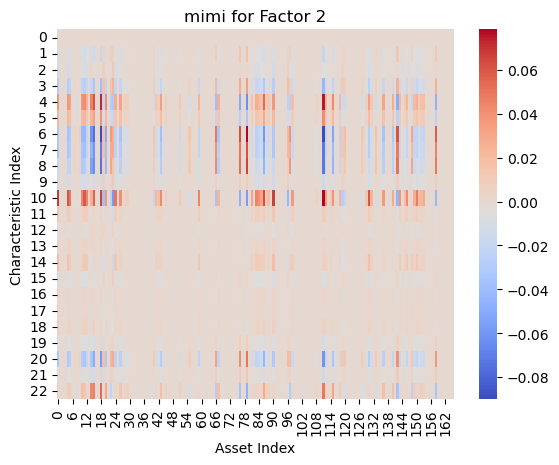

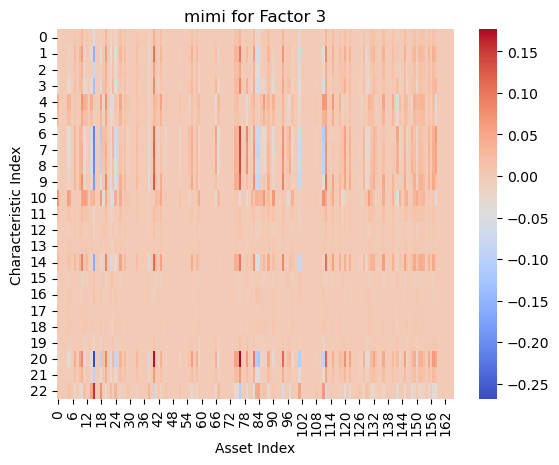

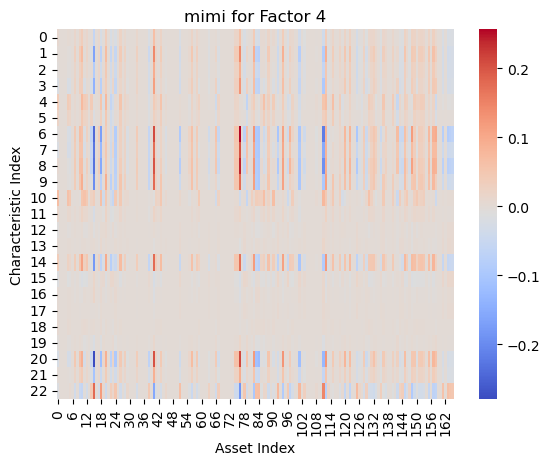

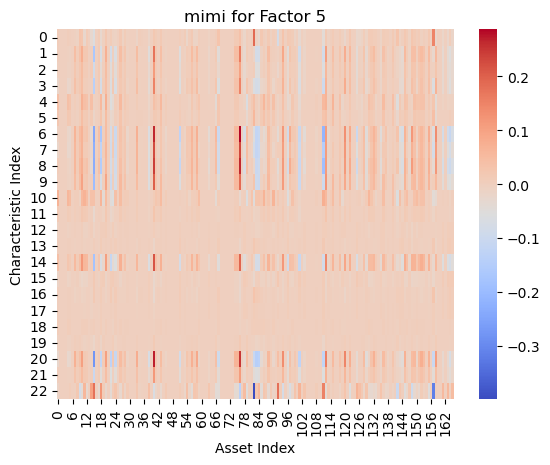

In [44]:
for j in range(results['mimi'].shape[2]):
    plt.figure()
    sns.heatmap(results['mimi'][:, :, j], cmap='coolwarm')
    plt.title(f'mimi for Factor {j+1}')
    plt.xlabel('Asset Index')
    plt.ylabel('Characteristic Index')
    plt.show()

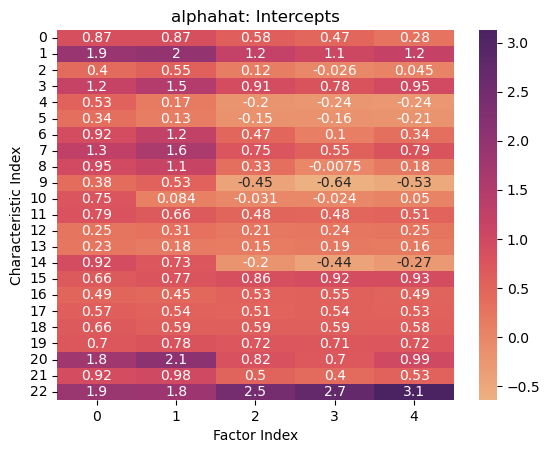

In [46]:
sns.heatmap(results['alphahat'], cmap='flare', annot=True)
plt.title('alphahat: Intercepts')
plt.xlabel('Factor Index')
plt.ylabel('Characteristic Index')
plt.show()

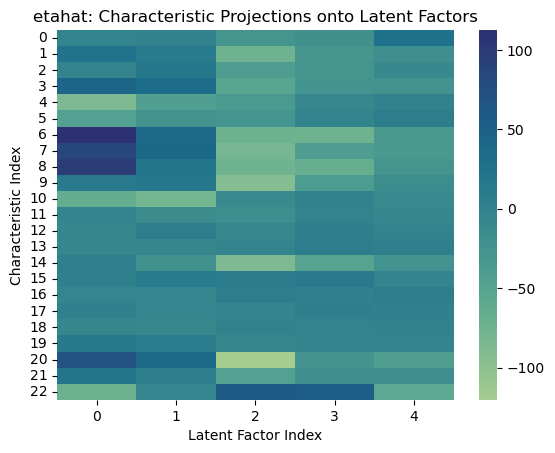

In [48]:
sns.heatmap(results['etahat'], cmap='crest')
plt.title('etahat: Characteristic Projections onto Latent Factors')
plt.xlabel('Latent Factor Index')
plt.ylabel('Characteristic Index')
plt.show()

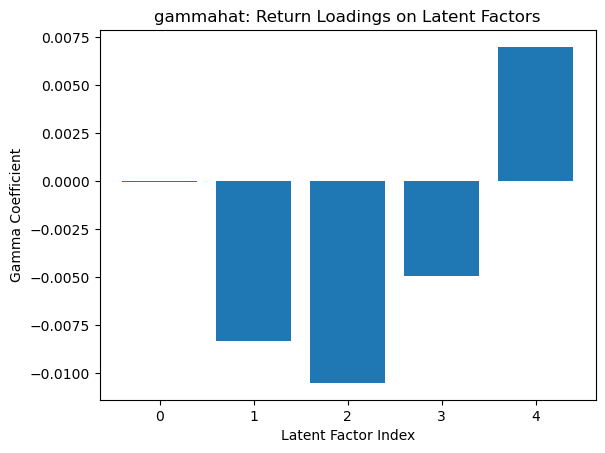

In [50]:
plt.bar(range(len(results['gammahat'])), results['gammahat'].flatten())
plt.title('gammahat: Return Loadings on Latent Factors')
plt.xlabel('Latent Factor Index')
plt.ylabel('Gamma Coefficient')
plt.show()